In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
a = 100 # excitatory 
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

In [22]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
def sigmoid(v, r):
    return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

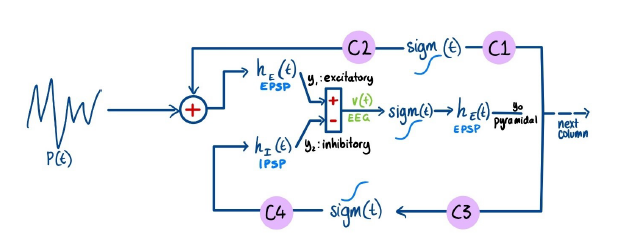

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


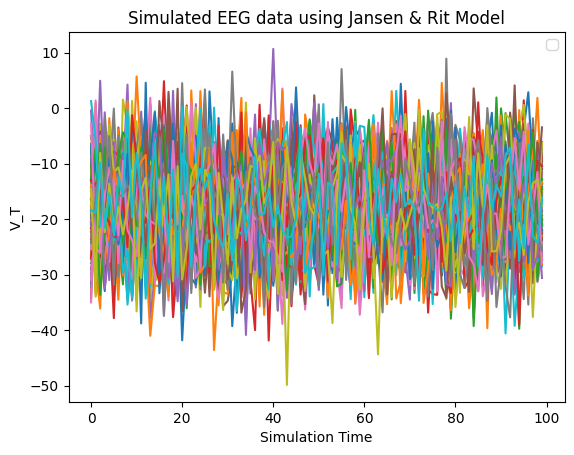

In [117]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

# Expanded Jansen & Rit Model 
def system_of_equations(x, alpha, beta, r_0, r_1, r_2, A, B, a, b, C, C1, C2, C3, C4):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y3 - a**2 * x3

    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


# Simulation parameters
dt = 0.01  # Step size
T = 100  # Simulation duration for stabilizing (with Euler method)
sim_length = 100 # Simulation time points (to plot)

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.1

# Array to store results
sol = np.zeros((int(T + sim_length/ dt), 8, num_nodes))
sol[0] = initial_conditions

# Run simulation using Euler method
for i in range(1, int(T + sim_length/ dt)):
    sol[i] = sol[i - 1] + dt * np.array(system_of_equations(sol[i - 1], alpha, beta, r_0, r_1, r_2, A, B, a, b, C, C1, C2, C3, C4))

# Plot EEG Results #################################################################
final_sol = sol[-sim_length:] # take the last sim_length time points, so sim_length * 8 * 100

final_x1 = final_sol[:, 2]
final_x2 = final_sol[:, 4]
final_x3 = final_sol[:, 6]

# Calculate V_T for each simulation point
V_T = np.zeros((sim_length, num_nodes))
for sim_point in range(sim_length):
    # Must produce (100, 1) vector
    V_T[sim_point] = C2 * final_x1[sim_point] - C4 * final_x2[sim_point] + C * alpha * calculate_zi(final_x3[sim_point])

# Plot V_T for each node
for node in range(num_nodes):
    plt.plot(V_T[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time')
plt.ylabel('V_T')
plt.title('Simulated EEG data using Jansen & Rit Model')

# Add legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


